Time of Flight until reaching target altitude: 38.02 seconds
Horizontal Distance traveled until reaching target altitude: 16201.39 meters
Final altitude: 1633.72 meters
Max Ord: 4118.27 meters


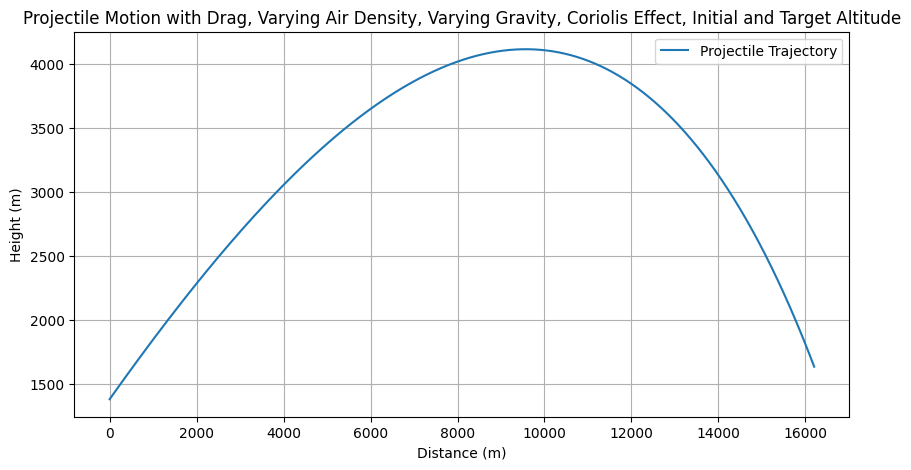

,t,x,y,z,vx,vy,QE,v_mag
0,0.00,0.000000,1379.000000,0.000000,614.850344,295.098381,455.800000,682.000000
1,0.01,6.146530,1381.949136,0.000052,614.652980,294.913553,455.678633,681.742100
2,0.02,12.291088,1384.896424,0.000103,614.455812,294.728799,455.557146,681.484416
3,0.03,18.433676,1387.841865,0.000155,614.258838,294.544117,455.435539,681.226950
4,0.04,24.574297,1390.785460,0.000207,614.062059,294.359508,455.313813,680.969699
...,...,...,...,...,...,...,...,...
3798,37.98,16188.988351,1644.849134,0.004762,310.283567,-277.743734,-743.691336,416.434237
3799,37.99,16192.090699,1642.069918,0.004714,310.234791,-277.921664,-744.095105,416.516599
3800,38.00,16195.192559,1639.288921,0.004665,310.186014,-278.099657,-744.498830,416.599067
3801,38.01,16198.293931,1636.506144,0.004616,310.137236,-278.277713,-744.902510,416.681642


In [34]:
# Here is my artillery Shot data calculations

from numpy import radians, sin, exp, cos, tan, sqrt, arctan, pi
import matplotlib.pyplot as plt
import pandas as pd

# Constants
EARTH_ANGULAR_VELOCITY = 7.2921e-5  # rad/s
gp = 14
# Inputs
# Example usage:
initial_velocity = 682.0
launch_angle = 455.8/3200*180
mass = 103.5/2.2
drag_coefficient = .25
radius = .155/2
area = radius**2*pi
latitude = 32 + 3/60 + 31/3600 # Frankfurt's approximate latitude
azimuth = 145/3200*180 # Firing due east
initial_altitude = 1379 # Launch altitude in meters
target_altitude = 1634 # Target altitude in meters
rho0 = 1.225 #float(input("Enter the air density at altitude (kg/m^3): "))
# Additional input for Magnus effect
spin_rate = initial_velocity/(20*.155) #float(input("Enter the projectile spin rate (revolutions per second): ")
spin_velocity = spin_rate * 2 * pi  # Convert from rev/s to rad/s


# Function to calculate gravitational acceleration with latitude
def gravity_with_latitude(latitude, gp=gp, alpha=0.0053024):
    latitude_rad = radians(latitude)
    return gp * (1 - alpha * cos(latitude_rad)**2)

# Function to calculate air density with altitude
def air_density_with_altitude(h, rho0=rho0, H=8500):
    return rho0 * exp(-h / H)

# Function to calculate the Coriolis force
def coriolis_force(vx, vy, latitude, azimuth):
    omega = EARTH_ANGULAR_VELOCITY
    latitude_rad = radians(latitude)
    azimuth_rad = radians(azimuth)
    
    # Coriolis acceleration in the east-west direction (x-axis)
    a_coriolis_x = 2 * omega * vy * cos(latitude_rad) * sin(azimuth_rad)
    
    # Coriolis acceleration in the north-south direction (y-axis)
    a_coriolis_y = 2 * omega * (vx * sin(latitude_rad) - vy * cos(latitude_rad) * cos(azimuth_rad))
    
    return a_coriolis_x, a_coriolis_y

# Function to calculate projectile motion with drag, varying air density, varying gravity, and the Coriolis effect
def projectile_motion_with_drag(v0, angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude):
    # Convert angle to radians
    angle_rad = radians(angle)
    
    # Initial velocity components
    v0x = v0 * cos(angle_rad)
    v0y = v0 * sin(angle_rad)
    # Velocity components
    vx = v0x
    vy = v0y
    
    # Time step for simulation
    dt = 0.01
    t = 0
    x = 0
    y = initial_altitude  # Set the initial altitude
    z = 0  # z-axis for Coriolis effect
    
    # Lists to store the trajectory points
    t_time = []
    x_points = []
    y_points = []
    z_points = []  # z-axis for Coriolis effect
    vx_comp = []
    vy_comp = []
    v_mag = []
    qe = []

    # Store the initial points
    t_time.append(t) # seconds
    x_points.append(x) # meters
    y_points.append(y) # meters
    z_points.append(z)  # z-axis for Coriolis effect
    vx_comp.append(v0x) # m/s
    vy_comp.append(v0y) # m/s
    v_mag.append(v0) # m/s
    qe.append(angle/180*3200) # trajectory in mils

    
    
    # Calculate the gravitational acceleration for the given latitude
    g = gravity_with_latitude(latitude)
    
    # Simulation loop
    while y >= 0:
        # Calculate the air density at current altitude
        rho = air_density_with_altitude(y)
        
        # Calculate the drag force
        F_drag_x = - (drag_coefficient * rho * area * vx**2) / (2 * mass)
        F_drag_y = - (drag_coefficient * rho * area * vy**2) / (2 * mass)
        
        # Calculate the Coriolis force
        F_coriolis_x, F_coriolis_y = coriolis_force(vx, vy, latitude, azimuth)
        
        # Update velocities
        vx += (F_drag_x + F_coriolis_x) * dt
        vy += (F_drag_y + F_coriolis_y - g) * dt
        
        # Update positions
        t += dt
        x += vx * dt
        y += vy * dt
        z += F_coriolis_x * dt  # z-axis for Coriolis effect
        
        # Store the points
        t_time.append(t) # seconds
        x_points.append(x)
        y_points.append(y)
        z_points.append(z)  # z-axis for Coriolis effect
        vx_comp.append(vx) #m/s
        vy_comp.append(vy)# m/s
        v_mag.append(sqrt(vx**2+vy**2)) # m/s
        qe.append(arctan(vy/vx)/pi*3200) #in mils
        
        # Check if the projectile has reached the target altitude
        if y <= target_altitude and vy < 0:
            break
        
                  
    return t, x, y, z, t_time,x_points, y_points, z_points,vx_comp,vy_comp,qe,v_mag

# Call the function and display the results
time_of_flight, final_x, final_y, final_z, t_time, x_vals, y_vals, z_vals, vx_comp, vy_comp, qe, v_mag = projectile_motion_with_drag(initial_velocity, launch_angle, mass, drag_coefficient, area, latitude, azimuth, initial_altitude, target_altitude)

shotdata = pd.DataFrame({'t':t_time,'x':x_vals,'y':y_vals,'z':z_vals, 'vx':vx_comp, 'vy':vy_comp, 'QE':qe,'v_mag':v_mag})
shotdata.to_csv('afatds_shotdata.csv')

# Note: The Coriolis effect is represented in the z-axis, which is not plotted in this 2D graph.
print(f"Time of Flight until reaching target altitude: {time_of_flight:.2f} seconds")
print(f"Horizontal Distance traveled until reaching target altitude: {final_x:.2f} meters")
print(f"Final altitude: {final_y:.2f} meters")
print(f"Max Ord: {max(y_vals):.2f} meters")

aa_dist = final_x
aa_qe = min(qe)
aa_v = v_mag[-1]
aa_maxord = max(y_vals)
# Plotting the trajectory
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, label='Projectile Trajectory')
plt.title('Projectile Motion with Drag, Varying Air Density, Varying Gravity, Coriolis Effect, Initial and Target Altitude')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')
plt.legend()
plt.grid(True)
plt.show()

shotdata
